In [21]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import numpy as np
import json
import requests
import asdf
from astropy import log
from astropy import wcs
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import extract_array

import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table

import astropy.units as u

from jwst import assign_wcs#.util.update_fits_wcsinfo
from jwst.datamodels import ImageModel

import sys
sys.path.append('../')
from codes import destreak
from codes import image1overf
from codes import smooth1overf

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['image.origin'] = 'lower'

os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [2]:
ls /orange/adamginsburg/jwst/cloudc/F4*/pipeline/*merged_i2d.fits

/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/F410M/pipeline/jw02221-o002_t001_nircam_clear-f410m-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/F466N/pipeline/jw02221-o002_t001_nircam_clear-f466n-merged_i2d.fits


In [3]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

In [4]:
#file = 'jw02221002001_08201_00004_nrcblong'
file = 'jw02221002001_02201_00001_nrcblong'
im = ImageModel(f'{basepath}/F405N/pipeline/{file}_destreak.fits')
cal = ImageModel(f'{basepath}/F405N/pipeline/{file}_cal.fits')

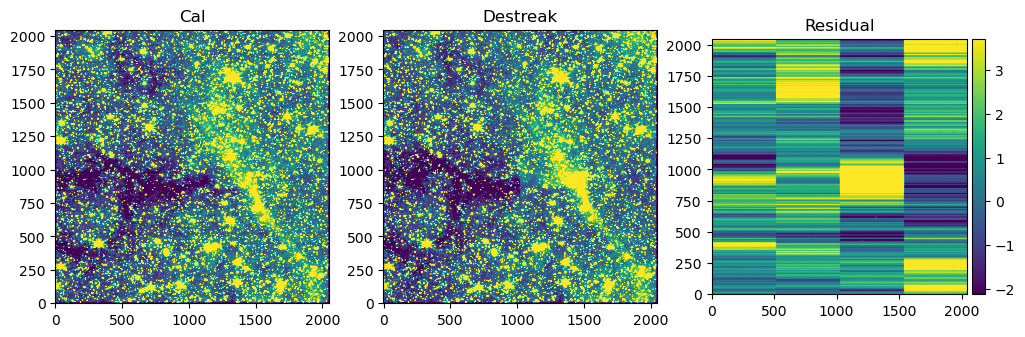

In [5]:
resid = im.data - cal.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [6]:
out_destreak = destreak.destreak(f'{basepath}/F405N/pipeline/{file}_cal.fits', percentile=10, median_filter_size=256, overwrite=False, write=False,
             #background_folder='/orange/adamginsburg/jwst/brick/images/',
             #background_mapping=background_mapping,
             use_background_map=False
             )

Destreaking /orange/adamginsburg/jwst/cloudc//F405N/pipeline/jw02221002001_02201_00001_nrcblong_cal.fits


2023-12-26 16:41:54,953 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/miniconda3/envs/python39savannah/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,



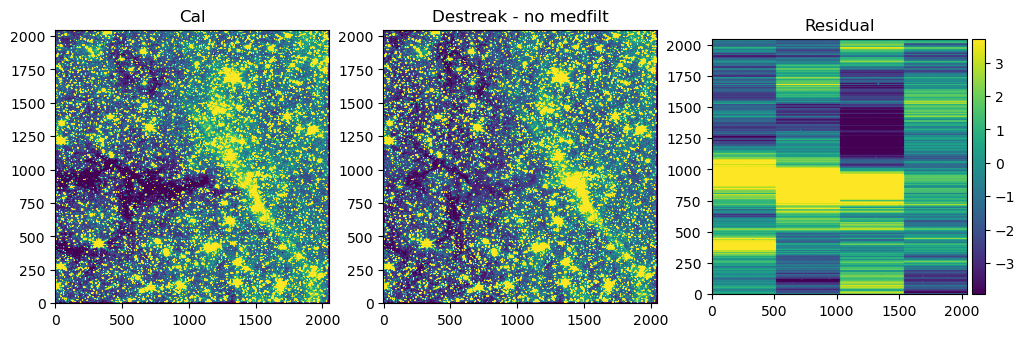

In [7]:
des = out_destreak['SCI']
resid = des.data - cal.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - no medfilt')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [9]:
out_im1overf = image1overf.sub1fimaging(fits.open(f'{basepath}/F405N/pipeline/{file}_cal.fits'), 3.0, 2.0, False, True)

2023-12-26 16:41:59,294 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/miniconda3/envs/python39savannah/lib/python3.9/site-packages/photutils/background/background_2d.py:274: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically masked.
  warnings.warn('Input data contains invalid values (NaNs or '

2023-12-26 16:42:00,089 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/convolution/convolve.py:428: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.
  warnings.warn(



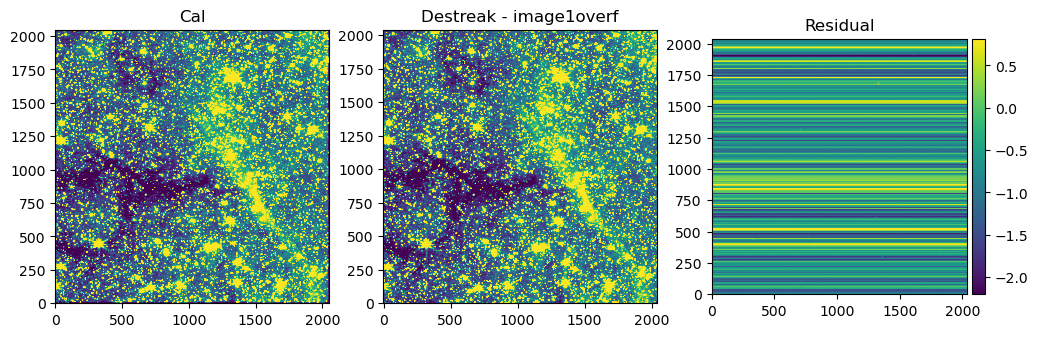

In [10]:
resid = out_im1overf.data - cal.data[4:2044,4:2044]

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [13]:
out_im1overf_col = image1overf.sub1fimaging(fits.open(f'{basepath}/F405N/pipeline/{file}_cal.fits'), 3.0, 2.0, True, True)

2023-12-26 16:50:37,191 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/miniconda3/envs/python39savannah/lib/python3.9/site-packages/photutils/background/background_2d.py:274: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically masked.
  warnings.warn('Input data contains invalid values (NaNs or '

2023-12-26 16:50:38,556 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/convolution/convolve.py:428: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.
  warnings.warn(



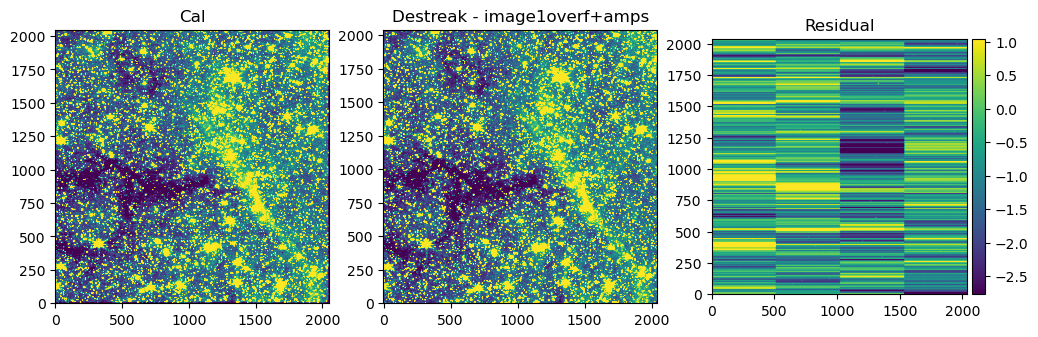

In [17]:
resid = out_im1overf_col.data - cal.data[4:2044,4:2044]

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [24]:
smo = smooth1overf.smooth_1overf_correction(cal.data)

2023-12-26 18:37:56,781 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/stats/sigma_clipping.py:368: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



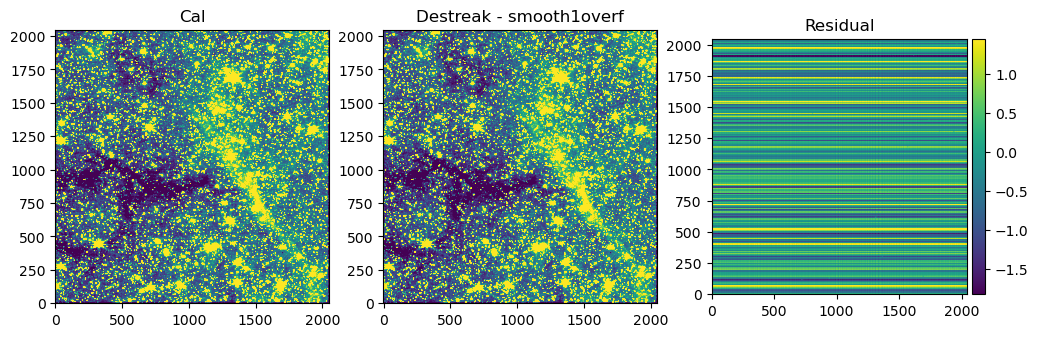

In [26]:
resid = smo - cal.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - smooth1overf')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

# Comparing Different Methods

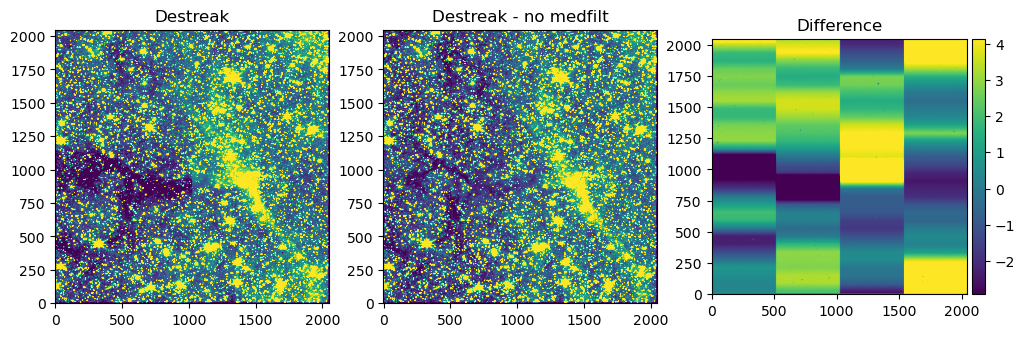

In [8]:
diff = im.data - des.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak')
axs[1].set_title('Destreak - no medfilt')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

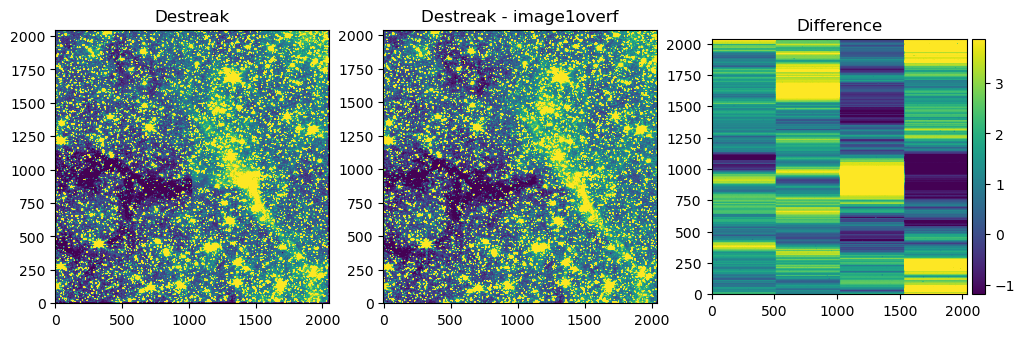

In [11]:
diff = im.data[4:2044,4:2044] - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

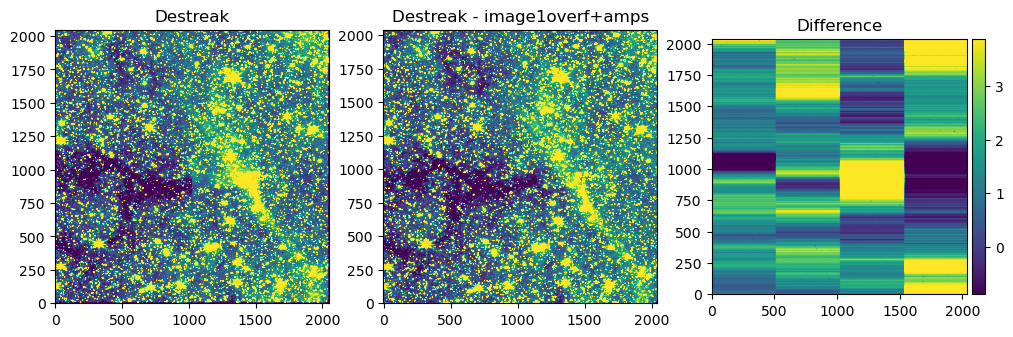

In [19]:
diff = im.data[4:2044,4:2044] - out_im1overf_col.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

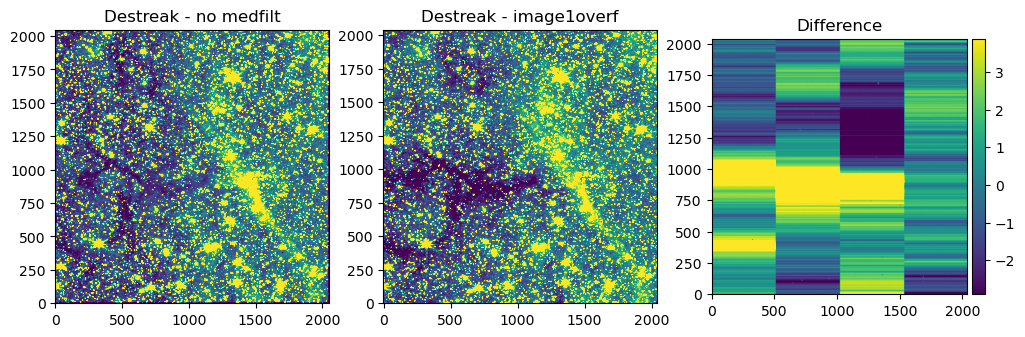

In [12]:
diff = des.data[4:2044,4:2044] - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - no medfilt')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

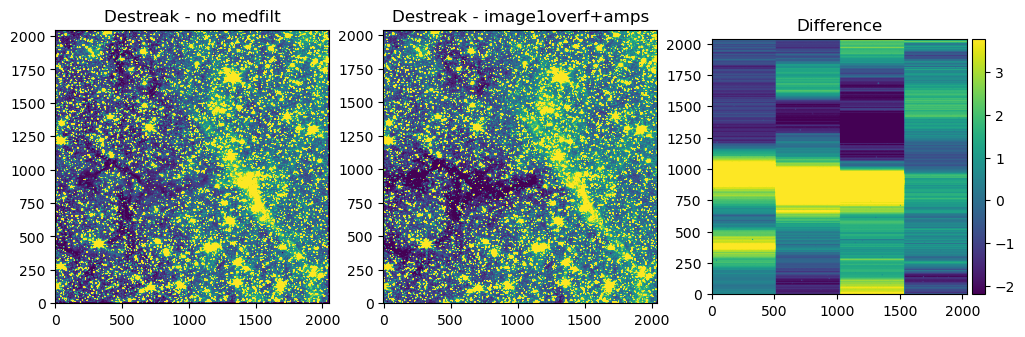

In [20]:
diff = des.data[4:2044,4:2044] - out_im1overf_col

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - no medfilt')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

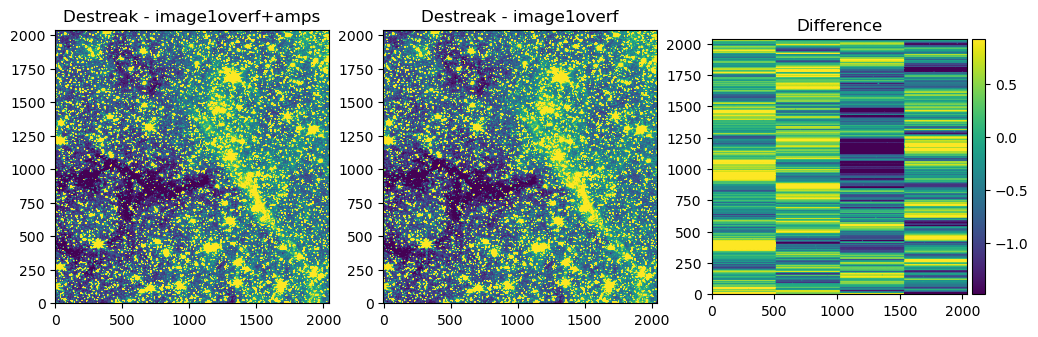

In [18]:
diff = out_im1overf_col - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - image1overf+amps')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

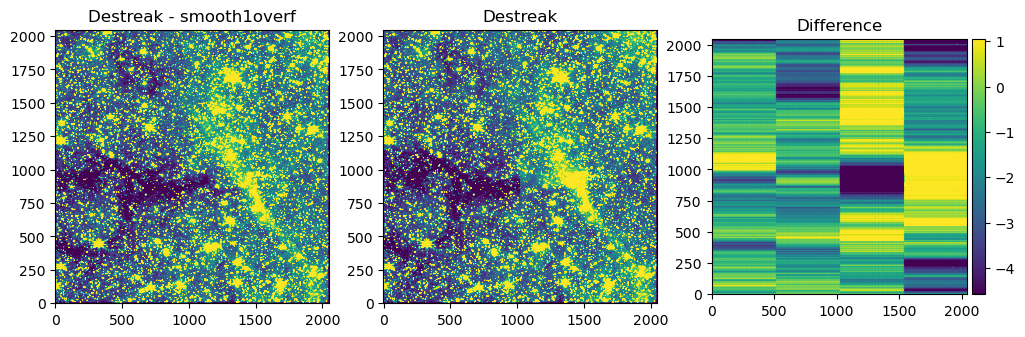

In [27]:
diff = smo - im.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

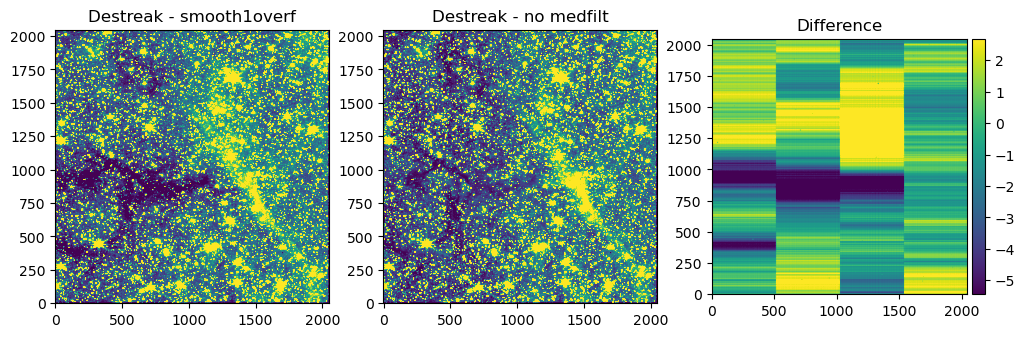

In [28]:
diff = smo - des.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak - no medfilt')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

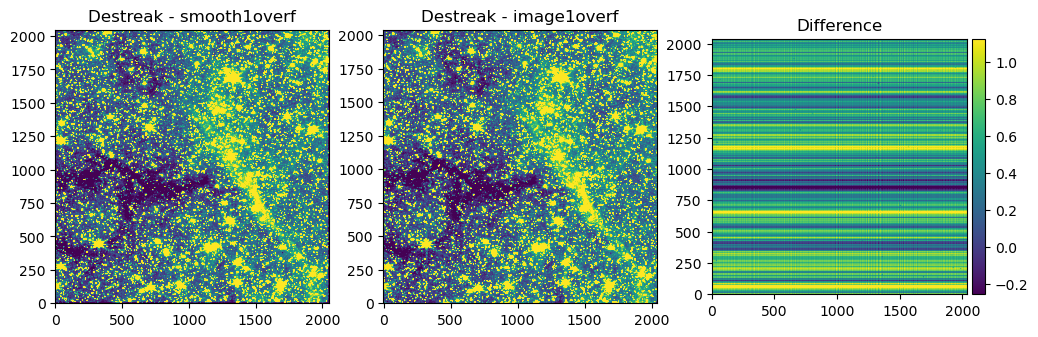

In [29]:
diff = smo[4:2044,4:2044] - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

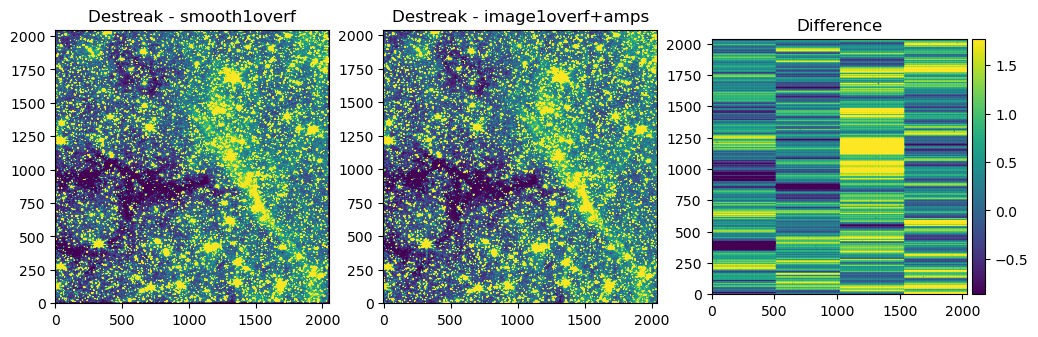

In [32]:
diff = smo[4:2044,4:2044] - out_im1overf_col

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [33]:
print('save')

save
